In [63]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np


In [64]:
# Carrega o dataset completo com preços, geração, load, e clima
df = pd.read_csv("dataset.csv", parse_dates=['time'])
df.set_index('time', inplace=True)

# Verifica se a coluna de preço está presente
print(df.columns[df.columns.str.contains("price", case=False)])


Index(['price day ahead', 'price actual'], dtype='object')


In [65]:
def add_lag_and_time_features(df):
    df = df.copy()
    df['lag_1h'] = df['price actual'].shift(1)
    df['lag_24h'] = df['price actual'].shift(24)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df.dropna()

df_prepared = add_lag_and_time_features(df)


In [66]:
def create_custom_sliding_windows(df):
    """
    Cria janelas fixas com:
    - Janela 1: treino 2015, teste 2016
    - Janela 2: treino 2016, teste 2017
    - Janela 3-A: treino 2016–2017, teste 2018
    - Janela 3-B: treino 2015–2017, teste 2018
    """
    df = df.copy()
    df = df.sort_index()

    splits = []

    configs = [
        ('2015-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),  # Janela 1
        ('2016-01-01', '2016-12-31', '2017-01-01', '2017-12-31'),  # Janela 2
        ('2016-01-01', '2017-12-31', '2018-01-01', '2018-12-31'),  # Janela 3-A
        ('2015-01-01', '2017-12-31', '2018-01-01', '2018-12-31')   # Janela 3-B
    ]

    for train_start, train_end, test_start, test_end in configs:
        df_train = df.loc[train_start:train_end]
        df_test = df.loc[test_start:test_end]
        splits.append((df_train, df_test))

    return splits

# Criar os splits
splits = create_custom_sliding_windows(df_prepared)

# Visualizar os períodos
for i, (train, test) in enumerate(splits, start=1):
    print(f"Janela {i}:")
    print(f"  Treino: {train.index.min().date()} → {train.index.max().date()}  ({len(train)} registos)")
    print(f"  Teste:  {test.index.min().date()} → {test.index.max().date()}  ({len(test)} registos)\n")


Janela 1:
  Treino: 2015-01-01 → 2015-12-31  (8737 registos)
  Teste:  2016-01-01 → 2016-12-31  (8784 registos)

Janela 2:
  Treino: 2016-01-01 → 2016-12-31  (8784 registos)
  Teste:  2017-01-01 → 2017-12-31  (8760 registos)

Janela 3:
  Treino: 2016-01-01 → 2017-12-31  (17544 registos)
  Teste:  2018-01-01 → 2018-12-31  (8759 registos)

Janela 4:
  Treino: 2015-01-01 → 2017-12-31  (26281 registos)
  Teste:  2018-01-01 → 2018-12-31  (8759 registos)



In [67]:
forecast_horizon = 168
df_prepared['target'] = df_prepared['price actual'].shift(-forecast_horizon)
df_prepared = df_prepared.dropna(subset=['target'])

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_linear_regression(df, train_start, train_end, test_start, test_end, forecast_horizon=168):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    # Hiperparâmetros (ajustáveis)
    fit_intercept = True
    normalize = False  # já usamos StandardScaler

    results = []
    
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        # Escalamento
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        # Modelo
        model = LinearRegression(fit_intercept=fit_intercept)
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # Métricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        # Avançar + contar progresso
        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [73]:
results_lr_window1 = longterm_sliding_expanding_linear_regression(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

mean_metrics = results_lr_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Métricas médias - Linear Regression (Window 2):")
print(mean_metrics.round(4))

results_lr_window2 = longterm_sliding_expanding_linear_regression(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

mean_metrics = results_lr_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Métricas médias - Linear Regression (Window 2):")
print(mean_metrics.round(4))

results_lr_window3 = longterm_sliding_expanding_linear_regression(
    df,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

mean_metrics = results_lr_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Métricas médias - Linear Regression (Window 2):")
print(mean_metrics.round(4))

results_lr_window4 = longterm_sliding_expanding_linear_regression(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

mean_metrics = results_lr_window4[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean()
print("📊 Métricas médias - Linear Regression (Window 2):")
print(mean_metrics.round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          8.9377
RMSE        10.4037
MAPE (%)    22.5861
rMAE         0.2000
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          6.9870
RMSE         8.7037
MAPE (%)    11.9764
rMAE         0.1158
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          8.5130
RMSE         9.9251
MAPE (%)    15.1867
rMAE         0.1365
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
📊 Métricas médias - Linear Regression (Window 2):
MAE          8.6435
RMSE        10.0758
MAPE (%)    14.9051
rMAE         0.1378
dty

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_rf(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [75]:
rf_results_window1 = longterm_sliding_expanding_rf(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(rf_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window2 = longterm_sliding_expanding_rf(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window3 = longterm_sliding_expanding_rf(
    df,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rf_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window4 = longterm_sliding_expanding_rf(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rf_results_window4[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          8.7986
RMSE        10.4056
MAPE (%)    22.0690
rMAE         0.1946
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          6.7552
RMSE         8.3656
MAPE (%)    11.3432
rMAE         0.1106
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.9503
RMSE         9.3772
MAPE (%)    14.1910
rMAE         0.1272
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.9329
RMSE         9.3527
MAPE (%)    13.9505
rMAE         0.1262
dtype: float64


In [76]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_xgb(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [77]:
rf_results_window1 = longterm_sliding_expanding_xgb(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(rf_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window2 = longterm_sliding_expanding_xgb(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window3 = longterm_sliding_expanding_xgb(
    df,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rf_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rf_results_window4 = longterm_sliding_expanding_xgb(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rf_results_window4[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          8.1308
RMSE         9.6235
MAPE (%)    20.3367
rMAE         0.1804
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          6.5791
RMSE         8.1659
MAPE (%)    11.0434
rMAE         0.1077
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.5683
RMSE         8.9469
MAPE (%)    13.7234
rMAE         0.1217
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.7427
RMSE         9.0741
MAPE (%)    13.6231
rMAE         0.1235
dtype: float64


In [88]:
def longterm_sliding_expanding_rnn(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    timesteps=24,
    units=50,
    epochs=10,
    batch_size=32,
    activation='tanh'
):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN, Dense, Input
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < forecast_horizon or len(df_train) < timesteps + 1:
            print(f"⚠️ Ignorado (dados insuficientes): {current_test_start.date()}")
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values

        y_train_shifted = y_train[timesteps:]
        X_train = X_train[:-timesteps]

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

        X_seq, y_seq = [], []
        for i in range(timesteps, len(X_train_scaled)):
            X_seq.append(X_train_scaled[i - timesteps:i])
            y_seq.append(y_train_scaled[i])
        X_seq, y_seq = np.array(X_seq), np.array(y_seq)

        model = Sequential()
        model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
        model.add(SimpleRNN(units=units, activation=activation))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        preds = []
        for i in range(forecast_horizon):
            if i + timesteps > len(df_test):
                break
            input_seq = df_test[feature_cols].iloc[i:i + timesteps].values
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        y_test = df_test['price actual'].iloc[timesteps:timesteps + len(preds)].values
        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            print(f"⚠️ Ignorado (sem dados válidos): {current_test_start.date()}")
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    if not results:
        print("⚠️ Nenhuma previsão válida foi registada.")
        return pd.DataFrame()

    return pd.DataFrame(results)


In [89]:
rnn_results_window2 = longterm_sliding_expanding_rnn(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rnn_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.4010
RMSE         8.8312
MAPE (%)    12.1586
rMAE         0.1199
dtype: float64


In [90]:
rnn_results_window1 = longterm_sliding_expanding_rnn(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(rnn_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rnn_results_window3 = longterm_sliding_expanding_rnn(
    df,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rnn_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

rnn_results_window4 = longterm_sliding_expanding_rnn(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(rnn_results_window4[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE         10.2367
RMSE        12.2093
MAPE (%)    27.1961
rMAE         0.2337
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          9.4429
RMSE        11.0815
MAPE (%)    17.3599
rMAE         0.1527
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          9.7712
RMSE        11.2385
MAPE (%)    17.6890
rMAE         0.1586
dtype: float64


In [91]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

def longterm_sliding_expanding_arima_glm(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    arima_order=(1, 0, 0)
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    feature_cols = [col for col in df.columns if col not in ['price actual', 'price day ahead']]
    results = []

    steps = (final_test_end - current_test_start).days + 1
    checkpoints = {int(steps * 0.25): "25%", int(steps * 0.5): "50%", int(steps * 0.75): "75%"}

    for step in range(0, steps, 7):  # avanço de 7 dias (long-term)
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_start = pd.to_datetime(test_start) + pd.Timedelta(days=step)
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        if current_test_end > final_test_end:
            break

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        if len(df_test) < forecast_horizon or len(df_train) < 200:
            continue

        # ARIMA para componente temporal
        try:
            arima_model = ARIMA(df_train['price actual'], order=arima_order)
            arima_result = arima_model.fit()
            arima_forecast = arima_result.forecast(steps=forecast_horizon)
        except:
            continue

        # GLM com variáveis explicativas
        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        glm = LinearRegression()
        glm.fit(X_train_scaled, y_train)
        glm_forecast = glm.predict(X_test_scaled)

        # Média simples das previsões ARIMA e GLM
        final_pred = (arima_forecast.values[:forecast_horizon] + glm_forecast[:forecast_horizon]) / 2

        mae = mean_absolute_error(y_test, final_pred)
        rmse = np.sqrt(mean_squared_error(y_test, final_pred))
        mape = mean_absolute_percentage_error(y_test, final_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

    if not results:
        print("⚠️ Nenhuma previsão válida foi gerada.")
        return pd.DataFrame()

    return pd.DataFrame(results)


In [92]:
arima_glm_results_window1 = longterm_sliding_expanding_arima_glm(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

# Ver média das métricas
print(arima_glm_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

arima_glm_results_window2 = longterm_sliding_expanding_arima_glm(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

# Ver média das métricas
print(arima_glm_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

arima_glm_results_window3 = longterm_sliding_expanding_arima_glm(
    df,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

# Ver média das métricas
print(arima_glm_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

arima_glm_results_window4 = longterm_sliding_expanding_arima_glm(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

# Ver média das métricas
print(arima_glm_results_window4[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 25% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

MAE          9.6888
RMSE        11.2080
MAPE (%)    27.6139
rMAE         0.2302
dtype: float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 25% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 75% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

MAE          7.4075
RMSE         8.8449
MAPE (%)    11.9435
rMAE         0.1180
dtype: float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 25% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 75% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

MAE          9.4032
RMSE        10.7065
MAPE (%)    16.4698
rMAE         0.1486
dtype: float64


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 25% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

⏳ Progresso: 75% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\s

MAE          9.1980
RMSE        10.5141
MAPE (%)    16.0614
rMAE         0.1457
dtype: float64


In [93]:
def longterm_sliding_expanding_lstm(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    timesteps=24,
    units=50,
    epochs=10,
    batch_size=32,
    activation='relu'
):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < forecast_horizon or len(df_train) < timesteps + 1:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values

        y_train_shifted = y_train[timesteps:]
        X_train = X_train[:-timesteps]

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

        # Criar sequências
        X_seq, y_seq = [], []
        for i in range(timesteps, len(X_train_scaled)):
            X_seq.append(X_train_scaled[i - timesteps:i])
            y_seq.append(y_train_scaled[i])
        X_seq, y_seq = np.array(X_seq), np.array(y_seq)

        # Modelo LSTM
        model = Sequential()
        model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
        model.add(LSTM(units=units, activation=activation))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        # Previsão sequencial
        preds = []
        for i in range(forecast_horizon):
            if i + timesteps > len(df_test):
                break
            input_seq = df_test[feature_cols].iloc[i:i + timesteps].values
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        y_test = df_test['price actual'].iloc[timesteps:timesteps + len(preds)].values
        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    if not results:
        print("⚠️ Nenhuma previsão válida foi registada.")
        return pd.DataFrame()

    return pd.DataFrame(results)


In [94]:
lstm_results_window1 = longterm_sliding_expanding_lstm(
    df,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(lstm_results_window1[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

lstm_results_window2 = longterm_sliding_expanding_lstm(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(lstm_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

lstm_results_window3 = longterm_sliding_expanding_lstm(
    df,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(lstm_results_window3[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

lstm_results_window4 = longterm_sliding_expanding_lstm(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(lstm_results_window4[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))


⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE         10.0392
RMSE        12.0302
MAPE (%)    26.8234
rMAE         0.2302
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          7.3035
RMSE         8.8324
MAPE (%)    11.8856
rMAE         0.1174
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          8.5188
RMSE        10.1160
MAPE (%)    15.9937
rMAE         0.1410
dtype: float64
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          8.6014
RMSE        10.2064
MAPE (%)    16.0749
rMAE         0.1422
dtype: float64


# XGBoost Tuning

In [ ]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_tunning_xgb(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [146]:
rf_tunning_results_window2 = longterm_sliding_expanding_tunning_xgb(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_tunning_results_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          6.6646
RMSE         8.2808
MAPE (%)    11.2296
rMAE         0.1092
dtype: float64


# Random Forest Tuning

In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def longterm_sliding_expanding_rf_tunning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    n_estimators=200,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=1,
    random_state=42
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    return pd.DataFrame(results)


In [162]:
rf_results_tunning_window2 = longterm_sliding_expanding_rf_tunning(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(rf_results_tunning_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
MAE          6.7638
RMSE         8.3687
MAPE (%)    11.3421
rMAE         0.1107
dtype: float64


# LSTM Tuning

In [165]:
def longterm_sliding_expanding_lstm_tunning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    timesteps=24,
    units=50,
    epochs=20,
    batch_size=16,
    activation='relu'
):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    results = []
    total_steps = ((final_test_end - current_test_start).days + 1) // 7
    checkpoints = {int(total_steps * 0.25): "25%", int(total_steps * 0.5): "50%", int(total_steps * 0.75): "75%"}

    step = 0
    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        if len(df_test) < forecast_horizon or len(df_train) < timesteps + 1:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values

        y_train_shifted = y_train[timesteps:]
        X_train = X_train[:-timesteps]

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train_shifted.reshape(-1, 1)).ravel()

        # Criar sequências
        X_seq, y_seq = [], []
        for i in range(timesteps, len(X_train_scaled)):
            X_seq.append(X_train_scaled[i - timesteps:i])
            y_seq.append(y_train_scaled[i])
        X_seq, y_seq = np.array(X_seq), np.array(y_seq)

        # Modelo LSTM
        model = Sequential()
        model.add(Input(shape=(X_seq.shape[1], X_seq.shape[2])))
        model.add(LSTM(units=units, activation=activation))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        # Previsão sequencial
        preds = []
        for i in range(forecast_horizon):
            if i + timesteps > len(df_test):
                break
            input_seq = df_test[feature_cols].iloc[i:i + timesteps].values
            input_seq_scaled = scaler_X.transform(input_seq).reshape((1, timesteps, len(feature_cols)))
            pred_scaled = model.predict(input_seq_scaled, verbose=0)[0][0]
            pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
            preds.append(pred)

        y_test = df_test['price actual'].iloc[timesteps:timesteps + len(preds)].values
        aligned_len = min(len(preds), len(y_test))
        if aligned_len == 0:
            current_test_start += pd.Timedelta(hours=forecast_horizon)
            step += 1
            continue

        mae = mean_absolute_error(y_test[:aligned_len], preds[:aligned_len])
        rmse = np.sqrt(mean_squared_error(y_test[:aligned_len], preds[:aligned_len]))
        mape = mean_absolute_percentage_error(y_test[:aligned_len], preds[:aligned_len]) * 100
        rmae = mae / np.mean(np.abs(y_test[:aligned_len]))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(hours=forecast_horizon)
        step += 1

    if not results:
        print("⚠️ Nenhuma previsão válida foi registada.")
        return pd.DataFrame()

    return pd.DataFrame(results)


In [ ]:
lstm_results_tunning_window2 = longterm_sliding_expanding_lstm_tunning(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(lstm_results_tunning_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

# ARIMA-GLM TUNING

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

def longterm_sliding_expanding_arima_glm_tunning(
    df,
    train_start,
    train_end,
    test_start,
    test_end,
    forecast_horizon=168,
    arima_order=(2, 1, 2)
):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    feature_cols = [col for col in df.columns if col not in ['price actual', 'price day ahead']]
    results = []

    steps = (final_test_end - current_test_start).days + 1
    checkpoints = {int(steps * 0.25): "25%", int(steps * 0.5): "50%", int(steps * 0.75): "75%"}

    for step in range(0, steps, 7):  # avanço de 7 dias (long-term)
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_start = pd.to_datetime(test_start) + pd.Timedelta(days=step)
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        if current_test_end > final_test_end:
            break

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        if len(df_test) < forecast_horizon or len(df_train) < 200:
            continue

        # ARIMA para componente temporal
        try:
            arima_model = ARIMA(df_train['price actual'], order=arima_order)
            arima_result = arima_model.fit()
            arima_forecast = arima_result.forecast(steps=forecast_horizon)
        except:
            continue

        # GLM com variáveis explicativas
        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        glm = LinearRegression()
        glm.fit(X_train_scaled, y_train)
        glm_forecast = glm.predict(X_test_scaled)

        # Média simples das previsões ARIMA e GLM
        final_pred = (arima_forecast.values[:forecast_horizon] + glm_forecast[:forecast_horizon]) / 2

        mae = mean_absolute_error(y_test, final_pred)
        rmse = np.sqrt(mean_squared_error(y_test, final_pred))
        mape = mean_absolute_percentage_error(y_test, final_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

    if not results:
        print("⚠️ Nenhuma previsão válida foi gerada.")
        return pd.DataFrame()

    return pd.DataFrame(results)


In [218]:
arima_glm_results_tunning_window2 = longterm_sliding_expanding_arima_glm_tunning(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

# Ver média das métricas
print(arima_glm_results_tunning_window2[['MAE', 'RMSE', 'MAPE (%)', 'rMAE']].mean().round(4))

c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gpere

⏳ Progresso: 25% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gpere

⏳ Progresso: 50% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gpere

⏳ Progresso: 75% da janela de teste


c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gpere

MAE          7.1348
RMSE         8.5057
MAPE (%)    11.7572
rMAE         0.1172
dtype: float64


# ARIMA 7 Day Forecast

c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\gpere\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


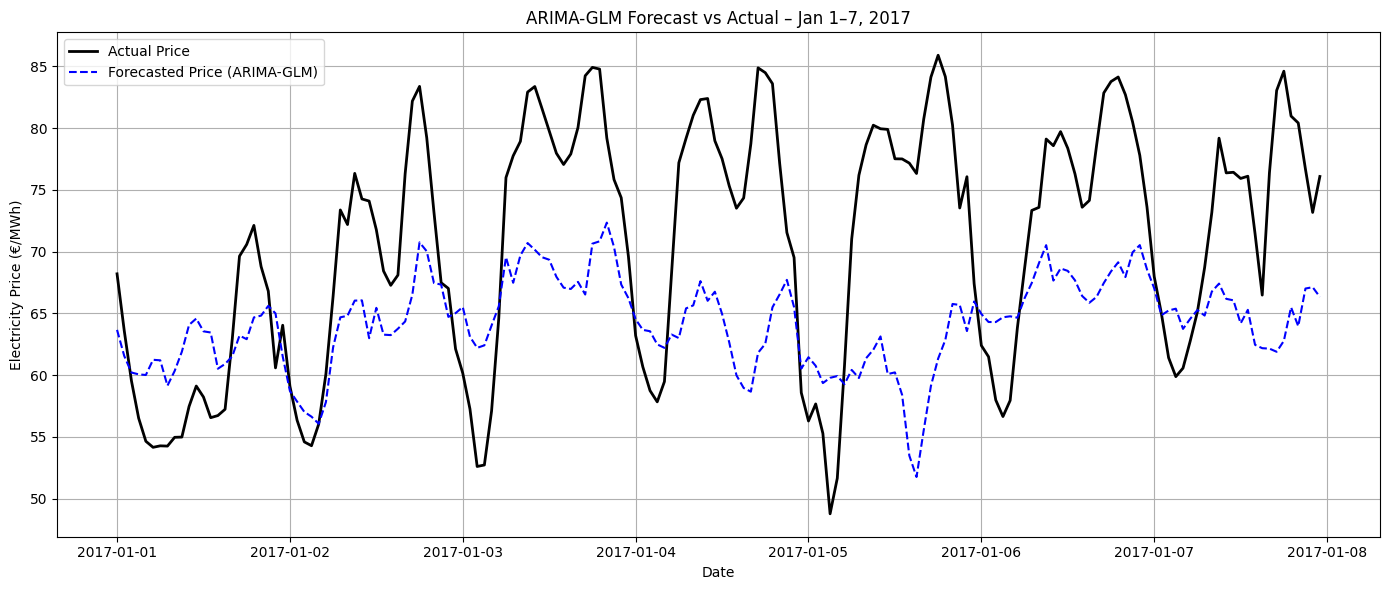

MAE:  8.94 €/MWh
RMSE: 10.79 €/MWh
MAPE: 12.06 %
rMAE: 0.1266


In [221]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Definir intervalo
train_start = '2016-01-01'
train_end = '2016-12-31'
test_start = '2017-01-01'
test_end = '2017-01-07 23:00:00'  # primeiros 7 dias

# Preparar dados
df_train = df.loc[train_start:train_end]
df_test = df.loc[test_start:test_end]

feature_cols = [col for col in df.columns if col not in ['price actual', 'price day ahead']]

# ARIMA
arima_model = ARIMA(df_train['price actual'], order=(2, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=168)

# GLM
X_train = df_train[feature_cols].values
X_test = df_test[feature_cols].values
y_test = df_test['price actual'].values

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

glm = LinearRegression()
glm.fit(X_train_scaled, df_train['price actual'].values)
glm_forecast = glm.predict(X_test_scaled)

# Combinação
y_pred = (arima_forecast.values[:168] + glm_forecast[:168]) / 2

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmae = mae / np.mean(np.abs(y_test))

# Gráfico
plt.figure(figsize=(14, 6))
plt.plot(df_test.index, y_test, label='Actual Price', color='black', linewidth=2)
plt.plot(df_test.index, y_pred, label='Forecasted Price (ARIMA-GLM)', color='blue', linestyle='--')
plt.title('ARIMA-GLM Forecast vs Actual – Jan 1–7, 2017')
plt.xlabel('Date')
plt.ylabel('Electricity Price (€/MWh)')
plt.legend()
plt.grid(True)

# Inserir métricas no gráfico
metrics_text = (
    f"MAE:  {mae:.2f} €/MWh\n"
    f"RMSE: {rmse:.2f} €/MWh\n"
    f"MAPE: {mape:.2f} %\n"
    f"rMAE: {rmae:.4f}"
)

plt.tight_layout()
plt.show()

print(f"MAE:  {mae:.2f} €/MWh")
print(f"RMSE: {rmse:.2f} €/MWh")
print(f"MAPE: {mape:.2f} %")
print(f"rMAE: {rmae:.4f}")


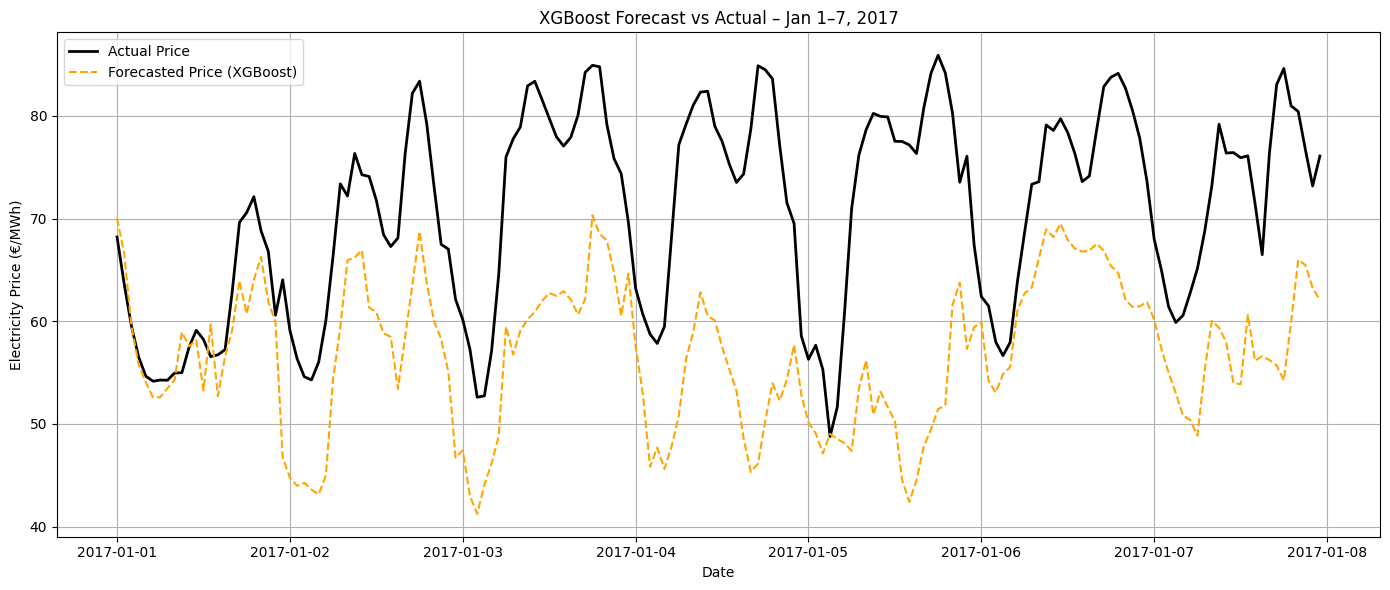

MAE:  14.00 €/MWh
RMSE: 16.50 €/MWh
MAPE: 18.94 %
rMAE: 0.1982


In [222]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Definir período de treino e teste
train_start = '2016-01-01'
train_end = '2016-12-31'
test_start = '2017-01-01'
test_end = '2017-01-07 23:00:00'  # primeiros 7 dias

# Preparar dados
df_train = df.loc[train_start:train_end]
df_test = df.loc[test_start:test_end]

drop_cols = ['price actual', 'price day ahead']
feature_cols = [col for col in df.columns if col not in drop_cols]

X_train = df_train[feature_cols].values
y_train = df_train['price actual'].values
X_test = df_test[feature_cols].values
y_test = df_test['price actual'].values

# Normalizar
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Instanciar e treinar modelo com melhores parâmetros
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train_scaled)

# Previsão
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmae = mae / np.mean(np.abs(y_test))

# Gráfico
plt.figure(figsize=(14, 6))
plt.plot(df_test.index, y_test, label='Actual Price', color='black', linewidth=2)
plt.plot(df_test.index, y_pred, label='Forecasted Price (XGBoost)', color='orange', linestyle='--')
plt.title('XGBoost Forecast vs Actual – Jan 1–7, 2017')
plt.xlabel('Date')
plt.ylabel('Electricity Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar métricas na consola
print(f"MAE:  {mae:.2f} €/MWh")
print(f"RMSE: {rmse:.2f} €/MWh")
print(f"MAPE: {mape:.2f} %")
print(f"rMAE: {rmae:.4f}")
